In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import json
#import matplotlib.pyplot as plt
#import seaborn as sns

import glob
import re

from utils import *

/homed/content/anaconda3/envs/python2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
SEMEVAL_BASE="/homed/smishra8/Code/Old_Codes/Code/DeepLearning/SemEval/Task-Sentiment/data/DOWNLOAD"
CLARIN_BASE="/homed/smishra8/Code/Old_Codes/Code/DeepLearning/TwitterDatasets/Tweets15Langs/data"
AIRLINE_BASE="/homed/smishra8/Code/Old_Codes/Code/DeepLearning/TwitterDatasets/CrowdFlower/data/airline"
GOP_DEBATE_BASE="/homed/smishra8/Code/Old_Codes/Code/DeepLearning/TwitterDatasets/CrowdFlower/data/gopdebate"
HCR_BASE="/homed/smishra8/Code/Old_Codes/Code/DeepLearning/TwitterDatasets/updown/data/hcr"
OBAMA_DEBATE_BASE="/homed/smishra8/Code/Old_Codes/Code/DeepLearning/TwitterDatasets/updown/data/shamma/orig"

In [3]:
DATA_FILE="{}/all_tweet_ids.txt.json".format(SEMEVAL_BASE)
arabic_files = glob.glob("{}/ARABIC/**/*.txt".format(SEMEVAL_BASE))
print_filenames(arabic_files, title="Arabic")
english_files = glob.glob("{}/Subtask*/*.txt".format(SEMEVAL_BASE))
print_filenames(english_files, title="English")

CLARIN_DATA_FILE="{}/all_english_ids.txt.json".format(CLARIN_BASE)
clarin_english_files = glob.glob("{}/English_Twitter_sentiment.csv".format(CLARIN_BASE))
print_filenames(clarin_english_files, title="Clarin English")

AIRLINE_FILE="{}/all_ids.txt.json".format(AIRLINE_BASE)
airline_files = glob.glob("{}/tweet_sentiments.txt".format(AIRLINE_BASE))
print_filenames(airline_files, title="Crowdflower airline")

GOP_DEBATE_FILE="{}/all_ids.txt.json".format(GOP_DEBATE_BASE)
gop_debate_files = glob.glob("{}/tweet_sentiments.txt".format(GOP_DEBATE_BASE))
print_filenames(gop_debate_files, title="Crowdflower gop debate")

HCR_FILE="{}/all_ids.txt.json".format(HCR_BASE)
hcr_files = glob.glob("{}/tweet_sentiments.txt".format(HCR_BASE))
print_filenames(hcr_files, title="HCR")

OBAMA_DEBATE_FILE="{}/all_ids.txt.json".format(OBAMA_DEBATE_BASE)
obama_debate_files = glob.glob("{}/tweet_sentiments.txt".format(OBAMA_DEBATE_BASE))
print_filenames(obama_debate_files, title="Obama McCain")

Arabic Files:
[0] /homed/smishra8/Code/Old_Codes/Code/DeepLearning/SemEval/Task-Sentiment/data/DOWNLOAD/ARABIC/TRAIN-ONLY/SemEval2017-task4-train-only.subtask-BD.arabic.txt
[1] /homed/smishra8/Code/Old_Codes/Code/DeepLearning/SemEval/Task-Sentiment/data/DOWNLOAD/ARABIC/TRAIN-ONLY/SemEval2017-task4-train-only.subtask-CE.arabic.txt
[2] /homed/smishra8/Code/Old_Codes/Code/DeepLearning/SemEval/Task-Sentiment/data/DOWNLOAD/ARABIC/TRAIN-ONLY/SemEval2017-task4-train-only.subtask-A.arabic.txt
[3] /homed/smishra8/Code/Old_Codes/Code/DeepLearning/SemEval/Task-Sentiment/data/DOWNLOAD/ARABIC/DEV/SemEval2017-task4-dev.subtask-BD.arabic.txt
[4] /homed/smishra8/Code/Old_Codes/Code/DeepLearning/SemEval/Task-Sentiment/data/DOWNLOAD/ARABIC/DEV/SemEval2017-task4-dev.subtask-CE.arabic.txt
[5] /homed/smishra8/Code/Old_Codes/Code/DeepLearning/SemEval/Task-Sentiment/data/DOWNLOAD/ARABIC/DEV/SemEval2017-task4-dev.subtask-A.arabic.txt

English Files:
[0] /homed/smishra8/Code/Old_Codes/Code/DeepLearning/SemEval

In [4]:
%%time
all_tweet_data=[]
for filename in [DATA_FILE, CLARIN_DATA_FILE,
                 AIRLINE_FILE, GOP_DEBATE_FILE,
                HCR_FILE, OBAMA_DEBATE_FILE]:
    with open(filename) as fp:
        for line in fp:
            t_data = json.loads(line.strip())
            all_tweet_data.append(t_data)
    print "Total %s tweets" % len(all_tweet_data)
    
TWEET_ID2DATA={}
for t_data in all_tweet_data:
    TWEET_ID2DATA[t_data[u'id']] = t_data
print len(TWEET_ID2DATA)

Total 43047 tweets
Total 104714 tweets
Total 116972 tweets
Total 127011 tweets
Total 130909 tweets
Total 133517 tweets
133508
CPU times: user 25.7 s, sys: 1.74 s, total: 27.4 s
Wall time: 27.4 s


In [5]:
all_tweet_data[0].keys()

[u'contributors',
 u'truncated',
 u'text',
 u'is_quote_status',
 u'in_reply_to_status_id',
 u'id',
 u'favorite_count',
 u'source',
 u'retweeted',
 u'coordinates',
 u'entities',
 u'in_reply_to_screen_name',
 u'id_str',
 u'retweet_count',
 u'in_reply_to_user_id',
 u'favorited',
 u'user',
 u'geo',
 u'in_reply_to_user_id_str',
 u'lang',
 u'created_at',
 u'in_reply_to_status_id_str',
 u'place']

In [6]:
def simple_extractor_func(t_data, line):
    user_info = t_data[u'user']
    entities_info = t_data[u'entities']
    return (t_data[u'id'],
            t_data[u'text'],
            t_data[u'favorite_count'],
            t_data[u'is_quote_status'],
            t_data[u'in_reply_to_status_id'] is not None,
            t_data[u'retweet_count'],
            user_info[u'id'],
            user_info[u'created_at'],
            user_info[u'followers_count'],
            user_info[u'friends_count'],
            user_info[u'listed_count'],
            user_info[u'statuses_count'],
            user_info[u'verified'],
            user_info[u'location'] != '',
            user_info[u'url'] is not None,
            len(entities_info[u'hashtags']),
            len(entities_info[u'symbols']),
            len(entities_info[u'urls']),
            len(entities_info[u'user_mentions']),
            t_data[u'created_at'],
           ) + tuple(line)

## Semeval data loading

In [7]:
file_extractor_params=[
    (("semeval", "english", "train"), english_files, r'.*201[3456]train.*A\.txt$'),
    (("semeval", "english", "dev"), english_files, r'.*201[3456]dev.*A\.txt$'),
    (("semeval", "english", "test"), english_files, r'.*201[3456]test.*A\.txt$'),
    (("semeval", "arabic", "train"), arabic_files, r'.*train.*A\.arabic\.txt$'),
    (("semeval", "arabic", "test"), arabic_files, r'.*dev.*A\.arabic\.txt$'),
]

datasets = dict()
for data_key, files, pattern in file_extractor_params:
    files = list(filter_filenames(files, pattern=re.compile(pattern)))
    print_filenames(files, title=data_key)
    file_data = sum((get_training_data(
        fname, TWEET_ID2DATA,
        extractor_func=simple_extractor_func
    ) for fname in files), [])
    print "Found data for %s instances" % len(file_data)
    datasets[data_key] = file_data

('semeval', 'english', 'train') Files:
[0] /homed/smishra8/Code/Old_Codes/Code/DeepLearning/SemEval/Task-Sentiment/data/DOWNLOAD/Subtask_A/twitter-2016train-A.txt
[1] /homed/smishra8/Code/Old_Codes/Code/DeepLearning/SemEval/Task-Sentiment/data/DOWNLOAD/Subtask_A/twitter-2015train-A.txt
[2] /homed/smishra8/Code/Old_Codes/Code/DeepLearning/SemEval/Task-Sentiment/data/DOWNLOAD/Subtask_A/twitter-2013train-A.txt

Missing data: 1006, number of annotater items: 1
Missing data: 118, number of annotater items: 1
Missing data: 2324, number of annotater items: 1
Found data for 12725 instances
('semeval', 'english', 'dev') Files:
[0] /homed/smishra8/Code/Old_Codes/Code/DeepLearning/SemEval/Task-Sentiment/data/DOWNLOAD/Subtask_A/twitter-2016devtest-A.txt
[1] /homed/smishra8/Code/Old_Codes/Code/DeepLearning/SemEval/Task-Sentiment/data/DOWNLOAD/Subtask_A/twitter-2013dev-A.txt
[2] /homed/smishra8/Code/Old_Codes/Code/DeepLearning/SemEval/Task-Sentiment/data/DOWNLOAD/Subtask_A/twitter-2016dev-A.txt

Mis

In [8]:
data_key, files, pattern = (("clarin", "english", "all"), clarin_english_files, r'.*')
files = list(filter_filenames(files, pattern=re.compile(pattern)))
print_filenames(files, title=data_key)
file_data = sum((get_training_data(
    fname, TWEET_ID2DATA,
    extractor_func=simple_extractor_func,
            sep=',', header=True,
            line_extractor=lambda x: [str.lower(k) for k in x[1:2]]
) for fname in files), [])
print "Found data for %s instances" % len(file_data)
datasets[data_key] = file_data

('clarin', 'english', 'all') Files:
[0] /homed/smishra8/Code/Old_Codes/Code/DeepLearning/TwitterDatasets/Tweets15Langs/data/English_Twitter_sentiment.csv

Reading header:  ('TweetID', 'HandLabel', 'AnnotatorID')
Missing data: 30377, number of annotater items: 1
Found data for 72657 instances


In [9]:
file_extractor_params=[
    (("airline", "english", "all"), airline_files, r'.*'),
    (("gop_debate", "english", "all"), gop_debate_files, r'.*'),
]
for data_key, files, pattern in file_extractor_params:
    files = list(filter_filenames(files, pattern=re.compile(pattern)))
    print_filenames(files, title=data_key)
    file_data = sum((get_training_data(
        fname, TWEET_ID2DATA,
        extractor_func=simple_extractor_func,
                sep='\t', header=True,
                line_extractor=lambda x: [str.lower(k) for k in x[1:2]]
    ) for fname in files), [])
    print "Found data for %s instances" % len(file_data)
    datasets[data_key] = file_data

('airline', 'english', 'all') Files:
[0] /homed/smishra8/Code/Old_Codes/Code/DeepLearning/TwitterDatasets/CrowdFlower/data/airline/tweet_sentiments.txt

Reading header:  ('tweet_id', 'sentiment', 'airline')
Missing data: 2227, number of annotater items: 1
Found data for 12258 instances
('gop_debate', 'english', 'all') Files:
[0] /homed/smishra8/Code/Old_Codes/Code/DeepLearning/TwitterDatasets/CrowdFlower/data/gopdebate/tweet_sentiments.txt

Reading header:  ('tweet_id', 'sentiment', 'candidate', 'subject_matter')
Missing data: 3806, number of annotater items: 1
Found data for 10031 instances


In [10]:
data_key, files, pattern = (("obama_debate", "english", "all"), obama_debate_files, r'.*')
files = list(filter_filenames(files, pattern=re.compile(pattern)))
print_filenames(files, title=data_key)
file_data = sum((get_training_data(
    fname, TWEET_ID2DATA,
    extractor_func=simple_extractor_func,
            sep='\t', header=True,
            line_extractor=lambda x: [str.lower(k) for k in x[1:2]]
) for fname in files), [])
print "Found data for %s instances" % len(file_data)
datasets[data_key] = file_data

('obama_debate', 'english', 'all') Files:
[0] /homed/smishra8/Code/Old_Codes/Code/DeepLearning/TwitterDatasets/updown/data/shamma/orig/tweet_sentiments.txt

Reading header:  ('tweet.id', 'sentiment')
Missing data: 630, number of annotater items: 1
Found data for 2608 instances


In [11]:
data_key, files, pattern = (("hcr", "english", "all"), hcr_files, r'.*')
files = list(filter_filenames(files, pattern=re.compile(pattern)))
print_filenames(files, title=data_key)
file_data = sum((get_training_data(
    fname, TWEET_ID2DATA,
    extractor_func=simple_extractor_func,
            sep='\t', header=True,
            line_extractor=lambda x: [str.lower(k) for k in x[1:3]]
) for fname in files), [])
print "Found data for %s instances" % len(file_data)
for datasplit in ["train", "dev", "test"]:
    file_data_split = map(lambda x: x[:-1], filter(lambda x: datasplit in x[-1], file_data))
    print "%s: %s" % (data_key[:-1] + (datasplit,), len(file_data_split))
    datasets[data_key[:-1] + (datasplit,)] = file_data_split

('hcr', 'english', 'all') Files:
[0] /homed/smishra8/Code/Old_Codes/Code/DeepLearning/TwitterDatasets/updown/data/hcr/tweet_sentiments.txt

Reading header:  ('tweet id', 'sentiment', 'filename')
Missing data: 383, number of annotater items: 2
Found data for 2131 instances
('hcr', 'english', 'train'): 690
('hcr', 'english', 'dev'): 724
('hcr', 'english', 'test'): 717


In [12]:
data_cols = ['tid', 'text', 'favorites', 'is_quote', 'is_reply', 'retweets',
             'u_id', 'u_created_at','u_followers', 'u_friends', 'u_lists', 'u_statuses',
             'u_verified', 'u_location','u_has_url',
             'n_hashtags', 'n_symbols', 'n_urls', 'n_mentions', 'created_at',
             'label']
new_cols = ["dataset", "language", "datasplit"]
df = []
for data_labels, data_items in datasets.iteritems():
    df_t = pd.DataFrame(data_items, columns=data_cols)
    print data_labels, df_t.shape
    df.append(df_t.assign(**dict(zip(new_cols, data_labels))))
print len(df)
df = pd.concat(df, axis=0)
print df.shape

('semeval', 'arabic', 'train') (2428, 21)
('semeval', 'arabic', 'test') (598, 21)
('semeval', 'english', 'dev') (4592, 21)
('semeval', 'english', 'test') (23201, 21)
('semeval', 'english', 'train') (12725, 21)
('clarin', 'english', 'all') (72657, 21)
('hcr', 'english', 'test') (717, 21)
('hcr', 'english', 'train') (690, 21)
('obama_debate', 'english', 'all') (2608, 21)
('hcr', 'english', 'dev') (724, 21)
('gop_debate', 'english', 'all') (10031, 21)
('airline', 'english', 'all') (12258, 21)
12
(143229, 24)


In [13]:
df.u_location.value_counts()

True     100723
False     42506
Name: u_location, dtype: int64

In [14]:
df.u_id.value_counts().head()

1240599805    113
320781491      63
118837027      55
15976697       49
13662722       47
Name: u_id, dtype: int64

In [15]:
df.u_id.value_counts().shape

(115778,)

/homed/content/anaconda3/envs/python2/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


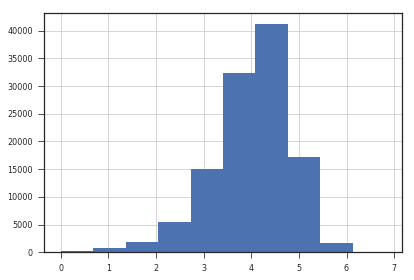

In [16]:
df[["u_id", "u_statuses"]].groupby("u_id").first().sort_values(
    "u_statuses", ascending=False).apply(lambda x: np.log10(x+1)).u_statuses.hist()


In [17]:
df[["u_id", "u_statuses"]].groupby("u_id").first().sort_values(
    "u_statuses", ascending=False).apply(lambda x: np.log10(x+1)).u_statuses.mean()

4.007822017422003

In [18]:
df[["tid", "u_id", "u_statuses"]].groupby(["tid", "u_id"]).first().sort_values("u_statuses", ascending=False).head()

,,u_statuses
tid,u_id,
511878434398543872,492532196,6510541
511868481319350273,492532196,6510541
511885958992904192,492532196,6510541
511448287573213184,2169277098,4014482
513229038035673088,1338951085,3377886


In [19]:
df.groupby("u_id").agg({"tid": max, "u_statuses": "first"}).sort_values("u_statuses", ascending=False).head()

,tid,u_statuses
u_id,,
492532196,511885958992904192,6510541
2169277098,511448287573213184,4014482
1338951085,513229038035673088,3377886
279118291,623859753568051200,3307959
59804598,513170741408169985,2762552


In [20]:
df.groupby("u_id").agg({"tid": max, "u_statuses": "first"}).sort_values("u_statuses", ascending=False).shape

(115778, 2)

In [21]:
df.groupby("u_id").agg(
    {"tid": max, "u_statuses": "first"}
).sort_values(
    "u_statuses", ascending=False
).to_csv("./data/tid_uid.txt", sep="\t")

! head data/tid_uid.txt

u_id	tid	u_statuses
492532196	511885958992904192	6510541
2169277098	511448287573213184	4014482
1338951085	513229038035673088	3377886
279118291	623859753568051200	3307959
59804598	513170741408169985	2762552
100986964	634897074417442816	2515470
1853213588	513026428003438593	2510061
68956490	10843026079	2497529
23138515	513300861326741504	2476273


In [22]:
df[["tid", "text"]].groupby("tid").first().head()

,text
tid,
936466992,Here we go. #tweetdebate
936467521,#tweetdebate letting mom/dad follow debate on ...
936467712,what is an appropriately bi-partisan food to b...
936468396,@current one minute to get your stuff together...
936468736,@current I've got the live stream going #curre...


In [23]:
df[["tid", "text"]].groupby("tid").first().shape

(131605, 1)

## Remove duplicates and fix labels

In [24]:
df["tid"].value_counts().head()

641548065040658436    3
785630797755736064    3
785630883797667840    3
626516723647315972    3
636871042791813120    3
Name: tid, dtype: int64

In [25]:
(df["tid"].value_counts() > 1).sum()

11616

In [26]:
df["tid"].value_counts()[(df["tid"].value_counts() > 1)].shape

(11616,)

In [27]:
df["tid"].value_counts()[(df["tid"].value_counts() > 1)].sum()

23240L

In [28]:
df[df["tid"].isin(
        df["tid"].value_counts()[
            (df["tid"].value_counts() > 1)
        ].index.tolist())][new_cols].assign(
    dataset_label=lambda x: x[new_cols].apply(
        lambda k: ",".join(k), axis=1)).dataset_label.value_counts()

clarin,english,all        21980
semeval,english,train       897
semeval,english,test        210
semeval,arabic,train         86
semeval,english,dev          62
semeval,arabic,test           4
gop_debate,english,all        1
Name: dataset_label, dtype: int64

In [29]:
df_t = pd.get_dummies(df[["tid", "label"]], columns=["label"]).groupby("tid").sum()
df_t.shape

(131605, 3)

In [30]:
df_t.head()

,label_negative,label_neutral,label_positive
tid,,,
936466992,0,1,0
936467521,0,1,0
936467712,0,1,0
936468396,0,1,0
936468736,0,0,1


In [31]:
df_t.ix[(df_t.sum(axis=1) > 1)].shape

/home/content/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  """Entry point for launching an IPython kernel.


(11616, 3)

In [32]:
df_t.head().values.tolist()

[[0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 0, 1]]

In [33]:
df_t.ix[(df_t.apply(lambda x: len(filter(lambda k: k != 0, x.values)), axis=1) > 1)].shape

(3395, 3)

In [34]:
df_t.ix[(df_t.apply(lambda x: len(filter(lambda k: k != 0, x.values)), axis=1) > 1)].head()

,label_negative,label_neutral,label_positive
tid,,,
100018506082435072,0,1,1
100154119884513280,1,0,1
256416307182985217,0,1,1
256787668367704066,0,1,1
259077598968180736,1,1,0


In [35]:
df[df["tid"].isin(df_t.ix[(df_t.apply(lambda x: len(filter(lambda k: k != 0, x.values)), axis=1) > 1)].index)][new_cols].head()

,dataset,language,datasplit
424,semeval,arabic,train
457,semeval,arabic,train
462,semeval,arabic,train
470,semeval,arabic,train
473,semeval,arabic,train


In [36]:
df[df["tid"].isin(df_t.ix[(df_t.apply(lambda x: len(filter(lambda k: k != 0, x.values)), axis=1) > 1)].index)][new_cols].assign(
    dataset_label=lambda x: x[new_cols].apply(
        lambda k: ",".join(k), axis=1)).dataset_label.value_counts()

clarin,english,all        6626
semeval,english,test        70
semeval,english,train       42
semeval,arabic,train        29
semeval,english,dev         23
gop_debate,english,all       1
Name: dataset_label, dtype: int64

In [37]:
df[df["tid"] == 785630797755736064][new_cols]

,dataset,language,datasplit
1724,semeval,arabic,train
1797,semeval,arabic,train
2147,semeval,arabic,train


In [38]:
df.tid.value_counts().head().to_dict()

{626516723647315972: 3,
 636871042791813120: 3,
 641548065040658436: 3,
 785630797755736064: 3,
 785630883797667840: 3}

In [39]:
def get_correct_label(g):
    labels = g.label.value_counts().to_dict()
    non_zero_labels = dict(filter(lambda x: x[1] != 0, labels.items()))
    if len(non_zero_labels) == 3:
        return "neutral"
    if len(non_zero_labels) == 1:
        return non_zero_labels.keys()[0]
    correct_label = [x for x in non_zero_labels.keys() if x != "neutral"][0]
    return correct_label

In [40]:
%%time
df_t = df[["tid", "label"]].groupby("tid").apply(get_correct_label)
df_t.head()

CPU times: user 1min 46s, sys: 1.04 s, total: 1min 47s
Wall time: 1min 46s


In [41]:
df_t.head()

tid
936466992     neutral
936467521     neutral
936467712     neutral
936468396     neutral
936468736    positive
dtype: object

In [42]:
df_t.shape

(131605,)

In [43]:
df_nodups = df.drop("label", axis=1).groupby("tid").first().merge(
    df_t.to_frame().rename(columns={0: "label"}),left_index=True, right_index=True).reset_index()
df_nodups.shape

(131605, 24)

In [44]:
df_nodups.head()

,tid,text,favorites,is_quote,is_reply,retweets,u_id,u_created_at,u_followers,u_friends,...,u_has_url,n_hashtags,n_symbols,n_urls,n_mentions,created_at,dataset,datasplit,language,label
0,936466992,Here we go. #tweetdebate,0,False,False,0,14898808,Sun May 25 13:52:19 +0000 2008,6872,1643,...,True,1,0,0,0,Sat Sep 27 01:00:06 +0000 2008,obama_debate,all,english,neutral
1,936467521,#tweetdebate letting mom/dad follow debate on ...,0,False,False,0,14187773,Thu Mar 20 22:25:49 +0000 2008,1456,664,...,False,1,0,0,0,Sat Sep 27 01:00:24 +0000 2008,obama_debate,all,english,neutral
2,936467712,what is an appropriately bi-partisan food to b...,0,False,False,0,14759482,Tue May 13 14:38:08 +0000 2008,718,1609,...,False,1,0,0,0,Sat Sep 27 01:00:32 +0000 2008,obama_debate,all,english,neutral
3,936468396,@current one minute to get your stuff together...,0,False,True,0,10450342,Wed Nov 21 20:25:33 +0000 2007,2381,3918,...,True,1,0,0,1,Sat Sep 27 01:00:58 +0000 2008,obama_debate,all,english,neutral
4,936468736,@current I've got the live stream going #curre...,0,False,True,0,15224134,Tue Jun 24 21:13:12 +0000 2008,875,2016,...,False,1,0,0,1,Sat Sep 27 01:01:13 +0000 2008,obama_debate,all,english,positive


## Write no duplicate data to files

In [45]:
df_nodups[["tid", "text"]].to_json("./data/joined_data_all.text.json",
                            orient="split",
                          force_ascii=False)

In [46]:
df_nodups = df_nodups.drop("text", axis=1)

In [47]:
df_nodups.shape

(131605, 23)

In [48]:
df_nodups.to_csv("./data/joined_data_all.txt", sep="\t", index=False)
! head ./data/joined_data_all.txt

tid	favorites	is_quote	is_reply	retweets	u_id	u_created_at	u_followers	u_friends	u_lists	u_statuses	u_verified	u_location	u_has_url	n_hashtags	n_symbols	n_urls	n_mentions	created_at	dataset	datasplit	language	label
936466992	0	False	False	0	14898808	Sun May 25 13:52:19 +0000 2008	6872	1643	161	4927	False	True	True	1	0	0	0	Sat Sep 27 01:00:06 +0000 2008	obama_debate	all	english	neutral
936467521	0	False	False	0	14187773	Thu Mar 20 22:25:49 +0000 2008	1456	664	31	1355	False	True	False	1	0	0	0	Sat Sep 27 01:00:24 +0000 2008	obama_debate	all	english	neutral
936467712	0	False	False	0	14759482	Tue May 13 14:38:08 +0000 2008	718	1609	60	5050	False	True	False	1	0	0	0	Sat Sep 27 01:00:32 +0000 2008	obama_debate	all	english	neutral
936468396	0	False	True	0	10450342	Wed Nov 21 20:25:33 +0000 2007	2381	3918	104	56628	False	True	True	1	0	0	1	Sat Sep 27 01:00:58 +0000 2008	obama_debate	all	english	neutral
936468736	0	False	True	0	15224134	Tue Jun 24 21:13:12 +0000 2008	875	2016	21	1924	False	True	Fa